# Reproducing Schneider et al 2017 - Parameter estimation in a perfect model setting with an Ensemble Kalman Filter

In this notebook, we will combine the L96 model with the EnKF to estimate parameters. We will start, however, with state estimation. This might come in handy layer and is a good learning experience in any case.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from L96 import *
from EnKF import *
import seaborn as sns
import matplotlib as mpl
sns.set_style('dark')
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (10,5)

## The Ensemble Kalman Filter

I will largely follow the notation used in Yvonne's thesis:

- $\mathbf{x}$: Model state. In the NWP case $\mathbf{x} = \begin{pmatrix} X \\ Y \end{pmatrix}$, or just $X$ in the one leve case. In the parameter estimation case, add the parameters $\mathbf{x} = \begin{pmatrix} X \\ Y \\ \theta\end{pmatrix}$
- $\mathbf{y}$: Observations. In the fully observable NWP setup these are the state variables. In the climate setup, these are observed/true long-term statistics.
- $h(\mathbf{x})$:  The observation operator that maps the model state to the observable. In case of the fully observable NWP setup, this is simple the state (without the parameters). In the climate setup, these are the model statistics computed from the model integration.


The EnKF algorithm goes as follows

**INSERT YVONNE'S ALGORITHM**

## State estimation with the one layer model

In [3]:
# Create initial conditions
l96 = L96OneLevel(dt=0.01)
l96.iterate(100)
init1level = l96.X.copy()

In [4]:
enkf = EnKF(
    l96=L96OneLevel(noprog=True), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=10
)

Dimensions: n = 36, m = 36


In [5]:
enkf.initialize(init1level, 1)

In [6]:
enkf.iterate(10)

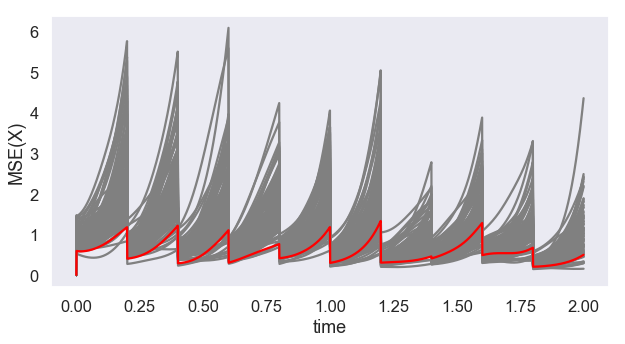

In [9]:
plot_mse(enkf)

## State estimation in the two layer model, only X is observed

In [35]:
# Create initial conditions
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
init2level = np.concatenate([initX, initY])

In [11]:
def H(l):
    return l.X

In [12]:
enkf = EnKF(
    l96=L96TwoLevel(noprog=True, save_dt=0.01), 
    nens=100, 
    obs_noise=1, 
    cyc_len=1, 
    mp=10,
    H=H
)

Dimensions: n = 396, m = 36


In [13]:
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))

In [14]:
enkf.iterate(5)

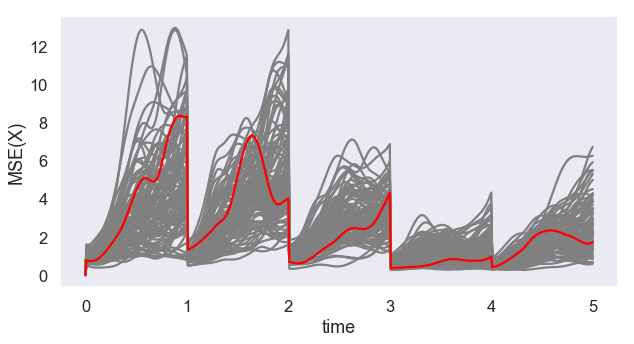

In [15]:
plot_mse(enkf)

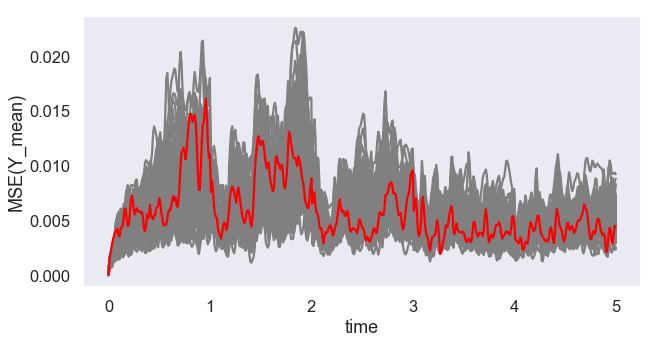

In [16]:
plot_mse(enkf, 'Y_mean')

## Joint state and parameter estimation in the one level model

In [17]:
def set_state(l, x_a):
    l.set_state(x_a[:-1])
    l.F = x_a[-1]

In [18]:
enkf = EnKF(
    l96=L96OneLevel(noprog=True), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=10, 
    get_state=lambda l: np.concatenate([l.state, np.atleast_1d(l.F)]),
    set_state=set_state
)

Dimensions: n = 37, m = 36


In [19]:
enkf.initialize(init1level, 1)

In [20]:
def init_F(l, prior, sigma):
    l.F = prior +  + np.random.normal(0, np.sqrt(sigma))

In [21]:
enkf.initialize_parameters(init_F, 15, 10)

In [22]:
enkf.iterate(5)

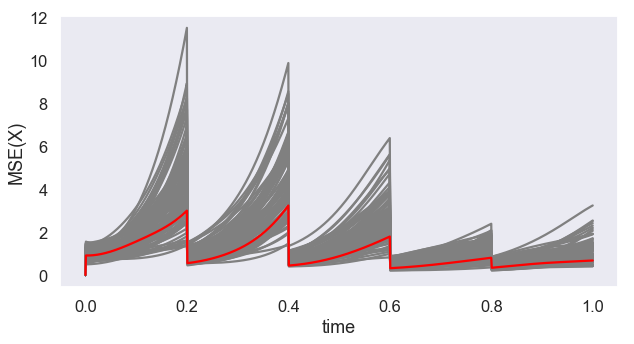

In [23]:
plot_mse(enkf)

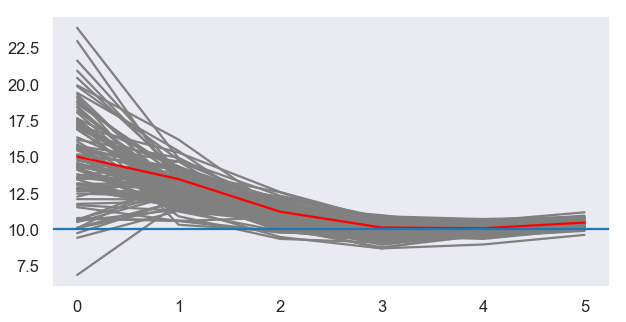

In [26]:
for i in range(100):
    plt.plot(np.array(enkf.parameter_history_ens)[:, i], c='gray')
plt.plot(np.array(enkf.parameter_history_det)[:], c='r')
plt.axhline(10)

## Joint state and parameter estimation in the two level model

In [27]:
def set_state(l, x_a):
    l.set_state(x_a[:-4])
    l.F = x_a[-4]
    l.h = x_a[-3]
    l.c = x_a[-2]
    l.b = x_a[-1]

In [28]:
enkf = EnKF(
    l96=L96TwoLevel(noprog=True, save_dt=0.01), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=10, 
    get_state=lambda l: np.concatenate([l.state, l.parameters]),
    set_state=set_state
)

Dimensions: n = 400, m = 396


In [29]:
enkf.initialize(init2level, 1)

In [30]:
def init_Fhcb(l, prior, sigma):
    l.F = prior[0] + np.random.normal(0, np.sqrt(sigma[0]))
    l.h = prior[1] + np.random.normal(0, np.sqrt(sigma[1]))
    l.c = np.exp(prior[2] + np.random.normal(0, np.sqrt(sigma[2])))
    l.b = prior[3] + np.random.normal(0, np.sqrt(sigma[3]))

In [31]:
enkf.initialize_parameters(init_Fhcb, priors=(10, 0, 2, 5), sigmas=(10, 1, 0.1, 10))

In [32]:
enkf.iterate(5)

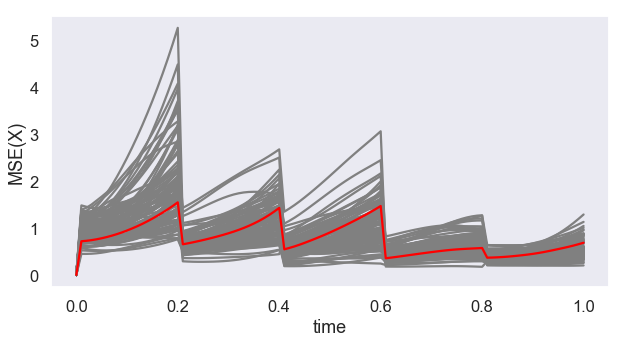

In [33]:
plot_mse(enkf)

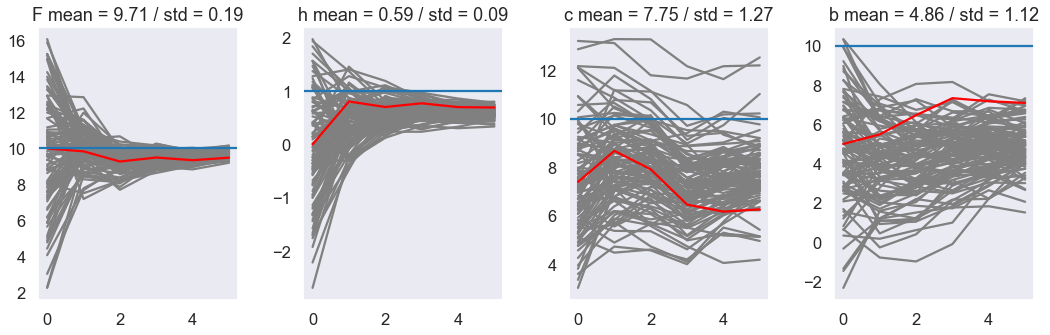

In [35]:
plot_params(enkf)

## Parameter estimation in a climate setup for the one level model

In [4]:
# Create initial conditions
l96 = L96OneLevel(dt=0.01)
l96.iterate(1000)

In [5]:
# Get climatological truth [X and X**2 for all grid points]
y = l96.mean_stats(0)

In [6]:
# As observation error, take the variance
obs_variance = l96.mean_stats(0, np.var)
r=0.5

In [7]:
def set_state(l, x_a):
    l.F = x_a

In [17]:
def H(l): return l.mean_stats(0)

In [19]:
enkf = EnKF(
    l96=L96OneLevel(noprog=True), 
    nens=100, 
    obs_noise=r**2 * obs_variance, 
    cyc_len=5, 
    mp=15, 
    get_state=lambda l: l.parameters,
    set_state=set_state,
    H=H,
    y=y,
    climate=True
)

Dimensions: n = 1, m = 72


In [20]:
enkf.initialize(init1level, 1)

In [21]:
def init_F(l, prior, sigma):
    l.F = prior +  + np.random.normal(0, np.sqrt(sigma))

In [22]:
enkf.initialize_parameters(init_F, 15, 10)

In [23]:
enkf.iterate(3)

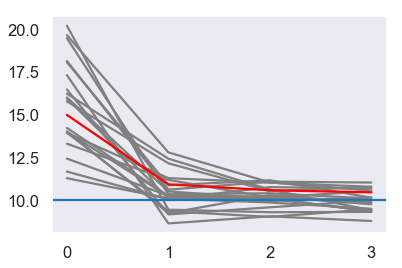

In [24]:
for i in range(20):
    plt.plot(np.array(enkf.parameter_history_ens)[:, i], c='gray')
plt.plot(np.array(enkf.parameter_history_det)[:], c='r')
plt.axhline(10)

In [25]:
# The climate error is defined as the std-weighted MSE of the obervables.
enkf.climate_error

[0.8498819067725134, 0.46252829822503144, 0.45288945168221917]

## Parameter estimation in the climate setup with the two level model = Schneider et al 2017

In [27]:
means = np.load('./data/L96TwoLevel_means.npy')

In [28]:
variances = np.load('./data/L96TwoLevel_variances.npy')

In [29]:
def set_state(l, x_a):
    l.F = x_a[-4]
    l.h = x_a[-3]
    l.c = x_a[-2]
    l.b = x_a[-1]

In [30]:
def init_Fhcb(l, prior, sigma):
    l.F = prior[0] + np.random.normal(0, np.sqrt(sigma[0]))
    l.h = prior[1] + np.random.normal(0, np.sqrt(sigma[1]))
    l.c = np.exp(prior[2] + np.random.normal(0, np.sqrt(sigma[2])))
    l.b = prior[3] + np.random.normal(0, np.sqrt(sigma[3]))

In [31]:
def H(l):
    return l.mean_stats(0)

In [32]:
r = 0.5

In [39]:
enkf = EnKF(
    l96=L96TwoLevel(noprog=True, save_dt=0.001, noYhist=True), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=100, 
    mp=15, 
    get_state=lambda l: l.parameters,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

Dimensions: n = 4, m = 180


In [40]:
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))

In [41]:
enkf.initialize_parameters(init_Fhcb, priors=(10, 0, 2, 5), sigmas=(10, 1, 0.1, 10))

In [42]:
enkf.iterate(10)

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Traceback (most recent call last):
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>


KeyboardInterrupt: 

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Traceback (most recent call last):
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f79f51e6c50>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
Traceback (most recent call last):
  File "/home/s/S.Rasp/minico

  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/filer/z-sv-pool12c/s/S.Rasp/repositories/AlphaLorenz/L96.py", line 172, in iterate
    self.step()
Traceback (most recent call last):
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/

  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/numpy/core/numeric.py", line 1466, in roll
    axis = normalize_axis_tuple(axis, a.ndim, allow_duplicate=True)
KeyboardInterrupt
KeyboardInterrupt
  File "/filer/z-sv-pool12c/s/S.Rasp/repositories/AlphaLorenz/L96.py", line 149, in step
    k1_Y = self._rhs_Y_dt(self.X, self.Y)
  File "/filer/z-sv-pool12c/s/S.Rasp/repositories/AlphaLorenz/L96.py", line 147, in step
    k4_X = self._rhs_X_dt(self.X + k3_X, B=B)
  File "/filer/z-sv-pool12c/s/S.Rasp/repositories/AlphaLorenz/L96.py", line 144, in step
    k1_X = self._rhs_X_dt(self.X, B=B)
  File "/filer/z-sv-pool12c/s/S.Rasp/repositories/AlphaLorenz/L96.py", line 152, in step
    k4_Y = self._rhs_Y_dt(self.X, self.Y + k3_Y)
  File "/filer/z-sv-pool12c/s/S.Rasp/repositories/AlphaLorenz/L96.py", line 110, in _rhs_X_dt
    X + se

In [ ]:
plot_params(enkf)

In [ ]:
plt.plot(enkf.climate_error);